In [6]:
from dotenv import load_dotenv
import os

load_dotenv()

google_maps_api_key = os.getenv('GOOGLE_MAPS_API_KEY')

if google_maps_api_key:
    print("Google Maps API Key loaded successfully.")
else:
    print("Google Maps API Key is not set.")

Google Maps API Key loaded successfully.


In [ ]:
import requests
import pandas as pd
import random

city_data = {
    "leeds": {
        "districts": [
            "LS1", "LS2", "LS3", "LS4", "LS5", "LS6", "LS7", "LS8", "LS9", "LS10",
            "LS11", "LS12", "LS13", "LS14", "LS15", "LS16", "LS17", "LS18", "LS19",
            "LS20", "LS21", "LS22", "LS23", "LS24", "LS25", "LS26", "LS27", "LS28", "LS29"
        ],
        "center": (53.8008, -1.5491)  # Leeds Station / City Square
    },
    "bristol": {
        "districts": ["BS1", "BS2", "BS3", "BS4", "BS5", "BS6", "BS7", "BS8", "BS9"],
        "center": (51.4545, -2.5879)  # Bristol city center
    },
    "sheffield": {
        "districts": ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9"],
        "center": (53.3811, -1.4701)  # Sheffield city center
    },
    "manchester": {
        "districts": ["M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9"],
        "center": (53.4808, -2.2426)  # Manchester Piccadilly area
    },
    "bradford": {
        "districts": ["BD1", "BD2"],
        "center": (53.791339256733295, -1.7495964004142226)  # Bradford Interchange Station
    },
    "london": {
        "districts": ["N1", "N2", "NW1", "SE1", "SW1", "E1", "W1", "EC1", "WC1"],
        "center": (51.507456071739284, -0.12759515903644522)  # Charing Cross, Central London
    }
}

city = "bristol"
districts = city_data[city]["districts"]
per_district_sample = 3

sampled_postcodes = []
for d in districts:
    sampled_postcodes.extend(fetch_sample_postcodes(d, per_district_sample))

batches = [sampled_postcodes[i:i+100] for i in range(0, len(sampled_postcodes), 100)]
geo_data = []
for batch in batches:
    geo_data.extend(bulk_geocode(batch))


# Add coords based on linear grid (take max and min of postcode lat/lon with even spacing), add random sample - done
# Add cluster of points centered around the district center - done
# Add random noise to the coordinates (avoides issue of clustering at the same postcode), scale by distance from center - done
# Add centre point of the city


# --- Final DataFrame of geocoded postcodes ---
df = pd.DataFrame(geo_data).dropna()
print(df.head())
print('Total num poscodes:', len(df))


  postcode        lat       lon
0  BS1 1DD  51.459757 -2.574944
1  BS1 1BU  51.453654 -2.593938
2  BS1 1DP  51.454904 -2.594327
3  BS2 0AF  51.455572 -2.580866
4  BS2 0AS  51.457986 -2.573094
Total num poscodes: 27


In [7]:
city_data = {
    "leeds": {
        "districts": [
            "LS1", "LS2", "LS3", "LS4", "LS5", "LS6", "LS7", "LS8", "LS9", "LS10",
            "LS11", "LS12", "LS13", "LS14", "LS15", "LS16", "LS17", "LS18", "LS19",
            "LS20", "LS21", "LS22", "LS23", "LS24", "LS25", "LS26", "LS27", "LS28", "LS29"
        ],
        "center": (53.8008, -1.5491)  # Leeds Station / City Square
    },
    "bristol": {
        "districts": ["BS1", "BS2", "BS3", "BS4", "BS5", "BS6", "BS7", "BS8", "BS9"],
        "center": (51.4545, -2.5879)  # Bristol city center
    },
    "sheffield": {
        "districts": ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9"],
        "center": (53.3811, -1.4701)  # Sheffield city center
    },
    "manchester": {
        "districts": ["M1", "M2", "M3", "M4", "M5", "M6", "M7", "M8", "M9"],
        "center": (53.4808, -2.2426)  # Manchester Piccadilly area
    },
    "bradford": {
        "districts": ["BD1", "BD2"],
        "center": (53.791339256733295, -1.7495964004142226)  # Bradford Interchange Station
    },
    "london": {
        "districts": ["N1", "N2", "NW1", "SE1", "SW1", "E1", "W1", "EC1", "WC1"],
        "center": (51.507456071739284, -0.12759515903644522)  # Charing Cross, Central London
    }
}

In [123]:
print('Total num poscodes before:', len(df))
m = plot_points(df)
m

df2 = add_grid_points(df, grid_size=10, sample_frac=0.1)
print('Total num poscodes after grid points:', len(df2))
m = plot_points(df2)
m


df2 = add_center_points(df2, city_data[city]["center"], n_points=10)
print('Total num poscodes after centre points:', len(df2))
m = plot_points(df2)
m


df2 = add_noise(df2, city_data[city]["center"], scale="uniform", noise_level=0.01)
print('Total num poscodes after noise:', len(df2))
m = plot_points(df2)
m


Total num poscodes before: 27
Total num poscodes after grid points: 37
Total num poscodes after centre points: 47
Total num poscodes after noise: 47


In [113]:
import folium
from folium.plugins import MarkerCluster

def plot_points(df, zoom_start=12, point_radius=4):
    """
    Plots all lat/lon points from a DataFrame on a folium map.
    
    Parameters:
        df (pd.DataFrame): Must contain 'lat' and 'lon' columns.
        zoom_start (int): Initial zoom level for the map.
        point_radius (int): Radius of the point markers.
    
    Returns:
        folium.Map: Interactive map with plotted points.
    """
    if df.empty or 'lat' not in df.columns or 'lon' not in df.columns:
        raise ValueError("DataFrame must contain 'lat' and 'lon' columns and not be empty.")

    center_point = [df['lat'].mean(), df['lon'].mean()]
    m = folium.Map(location=center_point, zoom_start=zoom_start, control_scale=True)
    marker_cluster = MarkerCluster().add_to(m)

    for _, row in df.iterrows():
        folium.CircleMarker(
            location=(row['lat'], row['lon']),
            radius=point_radius,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7
        ).add_to(m) # change to 'marker_cluster' for clustering when zoomed out

    return m


In [88]:
import numpy as np
import pandas as pd

def add_grid_points(df, grid_size=50, sample_frac=0.2):
    """
    Add randomly sampled grid points within the bounding box of the existing dataframe.
    
    Parameters:
        df (pd.DataFrame): Original dataframe with 'lat' and 'lon'
        grid_size (int): Number of grid points along one axis (grid_size x grid_size total points)
        sample_frac (float): Fraction of grid points to sample and append
    
    Returns:
        pd.DataFrame: Extended dataframe
    """
    lat_min, lat_max = df["lat"].min(), df["lat"].max()
    lon_min, lon_max = df["lon"].min(), df["lon"].max()

    lat_vals = np.linspace(lat_min, lat_max, grid_size)
    lon_vals = np.linspace(lon_min, lon_max, grid_size)
    lat_grid, lon_grid = np.meshgrid(lat_vals, lon_vals)

    grid_df = pd.DataFrame({
        "lat": lat_grid.ravel(),
        "lon": lon_grid.ravel()
    })

    # Random sample of the grid
    sample_size = int(sample_frac * len(grid_df))
    sampled_grid = grid_df.sample(n=sample_size, random_state=42).reset_index(drop=True)

    sampled_grid["postcode"] = "grid"
    return pd.concat([df, sampled_grid], ignore_index=True)

def add_center_points(df, center_point, n_points=20):
    """
    Adds multiple copies of the center point to the dataframe.
    
    Parameters:
        center_point (tuple): (lat, lon) of the city center
        n_points (int): Number of duplicates to add
    
    Returns:
        pd.DataFrame: Extended dataframe
    """
    lat, lon = center_point
    center_df = pd.DataFrame({
        "lat": [lat] * n_points,
        "lon": [lon] * n_points,
        "postcode": ["center"] * n_points
    })
    return pd.concat([df, center_df], ignore_index=True)

def add_noise(df, center_point, scale="uniform", noise_level=0.001):
    """
    Add noise to coordinates to avoid clustering at the same postcode.
    
    Parameters:
        df (pd.DataFrame): Dataframe with 'lat' and 'lon'
        center_point (tuple): (lat, lon) for scaling if needed
        scale (str): 'uniform' or 'distance_scaled'
        noise_level (float): Base noise level (in degrees)
    
    Returns:
        pd.DataFrame: Dataframe with noisy coordinates
    """
    df = df.copy()
    if scale == "uniform":
        df["lat"] += np.random.uniform(-noise_level, noise_level, size=len(df))
        df["lon"] += np.random.uniform(-noise_level, noise_level, size=len(df))
    elif scale == "distance_scaled":
        center_lat, center_lon = center_point
        distances = np.sqrt((df["lat"] - center_lat)**2 + (df["lon"] - center_lon)**2)
        scaled_noise = noise_level * distances / distances.max()
        df["lat"] += np.random.uniform(-1, 1, size=len(df)) * scaled_noise
        df["lon"] += np.random.uniform(-1, 1, size=len(df)) * scaled_noise
    else:
        raise ValueError("scale must be 'uniform' or 'distance_scaled'")
    return df

In [27]:
import time


def fetch_sample_postcodes(district, n_samples=10):
    """Fetch random sample of postcodes for a given district prefix."""
    url = f"https://api.postcodes.io/postcodes?q={district}"
    r = requests.get(url)
    if r.status_code != 200:
        return []
    results = r.json().get("result", [])
    all_postcodes = [r["postcode"] for r in results if r["postcode"].startswith(district)]
    return random.sample(all_postcodes, min(n_samples, len(all_postcodes)))


def bulk_geocode(postcodes):
    url = "https://api.postcodes.io/postcodes"
    headers = {"Content-Type": "application/json"}
    payload = {"postcodes": postcodes}
    r = requests.post(url, json=payload, headers=headers)
    results = r.json()["result"]
    return [
        {
            "postcode": res["query"],
            "lat": res["result"]["latitude"] if res["result"] else None,
            "lon": res["result"]["longitude"] if res["result"] else None
        }
        for res in results
    ]


def add_travel_times(df, center, api_key, mode="transit"):
    """
    Adds travel time (in minutes) from a central location to each lat/lon in df using Google Maps Distance Matrix API.

    Parameters:
    - df: DataFrame with 'lat' and 'lon' columns.
    - center: Tuple of (latitude, longitude) for the origin.
    - api_key: Your Google API key.
    - mode: One of 'driving', 'walking', 'bicycling', or 'transit'.

    Returns:
    - DataFrame with a new 'travel_time_mins' column.
    """
    base_url = "https://maps.googleapis.com/maps/api/distancematrix/json"
    origins = f"{center[0]},{center[1]}"
    travel_times = []

    for _, row in df.iterrows():
        destination = f"{row['lat']},{row['lon']}"
        params = {
            "origins": origins,
            "destinations": destination,
            "mode": mode,
            "key": api_key
        }
        response = requests.get(base_url, params=params)
        data = response.json()

        try:
            duration_seconds = data["rows"][0]["elements"][0]["duration"]["value"]
            travel_times.append(duration_seconds / 60)  # convert to minutes
        except (KeyError, IndexError, TypeError):
            travel_times.append(None)

        time.sleep(1)  # pause to respect API rate limits

    df = df.copy()
    df["travel_time_mins"] = travel_times
    return df


In [124]:

# df_with_times = add_travel_times(df, city_data[city]["center"], google_maps_api_key, mode="transit")
df_with_times2 = add_travel_times(df2, city_data[city]["center"], google_maps_api_key, mode="transit")
print(df_with_times2.head())

  postcode        lat       lon  travel_time_mins
0  BS1 1DD  51.467406 -2.573868         27.433333
1  BS1 1BU  51.449881 -2.587239         11.516667
2  BS1 1DP  51.445134 -2.591198         19.350000
3  BS2 0AF  51.453821 -2.571873         23.316667
4  BS2 0AS  51.459307 -2.563465         20.250000


In [8]:
print(city)
print(city_data[city]["center"])

bradford
(53.791339256733295, -1.7495964004142226)


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import numpy as np

def plot_travel_times_with_contours(df, center_point, title="Travel Times from City Centre", cmap="viridis"):
    """
    Plots coordinates colored by travel time, with contour lines.
    
    Parameters:
    - df: DataFrame with 'lat', 'lon', and 'travel_time_mins' columns
    - center_point: Tuple (lat, lon) for central location
    - title: Plot title
    - cmap: Colormap for travel time
    """
    lats = df["lat"].values
    lons = df["lon"].values
    times = df["travel_time_mins"].values

    # Create a grid to interpolate over
    grid_lon, grid_lat = np.meshgrid(
        np.linspace(min(lons), max(lons), 200),
        np.linspace(min(lats), max(lats), 200)
    )
    
    # Interpolate travel times over the grid
    grid_times = griddata(
        points=(lons, lats),
        values=times,
        xi=(grid_lon, grid_lat),
        method='cubic'
    )

    plt.figure(figsize=(10, 8))
    plt.contourf(grid_lon, grid_lat, grid_times, levels=15, cmap=cmap, alpha=0.75)
    contour = plt.contour(grid_lon, grid_lat, grid_times, levels=10, colors='k', linewidths=0.5)
    plt.clabel(contour, inline=True, fontsize=8)

    # Scatter actual data points
    sc = plt.scatter(lons, lats, c=times, cmap=cmap, edgecolor='black', linewidth=0.5, s=50, label="Sampled Points")

    # Mark the center point
    plt.scatter(center_point[1], center_point[0], c='red', s=100, marker='x', label='City Centre')

    plt.colorbar(sc, label="Travel Time (minutes)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

import folium
from folium import plugins
import branca.colormap as cm

def plot_folium_travel_map(df, center_point, map_title="Travel Time Map"):
    """
    Create an interactive Folium map with travel times from a city center.

    Parameters:
    - df: DataFrame with 'lat', 'lon', 'travel_time_mins'
    - center_point: (lat, lon) of city center
    - map_title: Title string (used in map popup)
    """
    # Set up color scale based on travel time range
    min_time = df["travel_time_mins"].min()
    max_time = df["travel_time_mins"].max()
    #colormap = cm.linear.Viridis.scale(min_time, max_time)
    colormap = cm.linear.YlGnBu_09.scale(min_time, max_time)
    colormap.caption = "Travel Time (minutes)"

    # Create base map
    fmap = folium.Map(location=center_point, zoom_start=12, tiles="cartodbpositron")

    # Add center marker
    folium.Marker(
        location=center_point,
        popup="City Centre",
        icon=folium.Icon(color='red', icon='glyphicon glyphicon-star')
    ).add_to(fmap)

    # Add circle markers for each point
    for _, row in df.iterrows():
        folium.CircleMarker(
            location=(row['lat'], row['lon']),
            radius=6,
            color=colormap(row['travel_time_mins']),
            fill=True,
            fill_opacity=0.8,
            popup=f"{row['postcode']}: {row['travel_time_mins']:.1f} mins"
        ).add_to(fmap)

    # Add colormap
    fmap.add_child(colormap)

    return fmap



In [43]:
#plot_travel_times_with_contours(df_with_times, center_point=city_data["bradford"]["center"], title="Bradford Travel Times")

m = plot_folium_travel_map(df_with_times, center_point=city_data["bradford"]["center"])
m

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from PIL import Image
import folium
from folium.raster_layers import ImageOverlay
from folium.plugins import FloatImage
import os

def plot_travel_time_heatmap_folium(df, center_point, zoom_start=12, image_path="heatmap_overlay.png", show_contours=True, show_markers=True, show_center_marker=True):
    """
    Interpolates travel times and overlays a heatmap + contour image onto a folium map.
    """
    # Extract coordinates and values
    lats = df["lat"].values
    lons = df["lon"].values
    times = df["travel_time_mins"].values

    # Define grid for interpolation
    grid_res = 300  # higher = finer resolution
    lon_lin = np.linspace(lons.min(), lons.max(), grid_res)
    lat_lin = np.linspace(lats.min(), lats.max(), grid_res)
    lon_grid, lat_grid = np.meshgrid(lon_lin, lat_lin)

    # Interpolate travel times to grid
    grid_z = griddata(
        points=(lons, lats),
        values=times,
        xi=(lon_grid, lat_grid),
        method='linear' # linear or cubic
    )

    # Apply Gaussian smoothing
    grid_z = gaussian_filter(grid_z, sigma=3)  # Adjust sigma as needed
    #grid_z = np.nan_to_num(grid_z_smooth, nan=np.nanmax(grid_z_smooth))

    # Create figure and plot
    fig, ax = plt.subplots(figsize=(8, 8))
    if show_contours:
        contour = ax.contourf(lon_grid, lat_grid, grid_z, levels=15, cmap="viridis_r", alpha=0.8)
        c_lines = ax.contour(lon_grid, lat_grid, grid_z, levels=15, colors='black', linewidths=0.5)
        ax.clabel(c_lines, inline=True, fontsize=8, fmt="%.0f min")

    # Remove axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

    # Save to PNG with transparent background
    fig.savefig(image_path, transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

    # Load image size
    img = Image.open(image_path)
    width, height = img.size

    # Determine map bounds from data
    bounds = [[lat_lin.min(), lon_lin.min()], [lat_lin.max(), lon_lin.max()]]

    # Create folium map
    m = folium.Map(location=center_point, zoom_start=zoom_start, control_scale=True)

    # Add point markers
    if show_markers:
        for _, row in df.iterrows():
            folium.CircleMarker(
                location=(row["lat"], row["lon"]),
                radius=4,
                fill=True,
                color="white",
                fill_color="red",
                fill_opacity=0.8,
                popup=f"{row['postcode']}<br>{row['travel_time_mins']:.1f} min"
            ).add_to(m)

    if show_center_marker:
        folium.Marker(
            location=center_point,
            popup="City Center",
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(m)

    # Overlay image
    img_overlay = ImageOverlay(
        name="Travel Time Heatmap",
        image=image_path,
        bounds=bounds,
        opacity=0.6,
        interactive=True,
        cross_origin=False
    )
    img_overlay.add_to(m)

    folium.LayerControl().add_to(m)

    return m



[26.01538947 25.93246911 26.03798712 ... 38.68924274 38.69679216
 38.68794401]
(53.791339256733295, -1.7495964004142226)



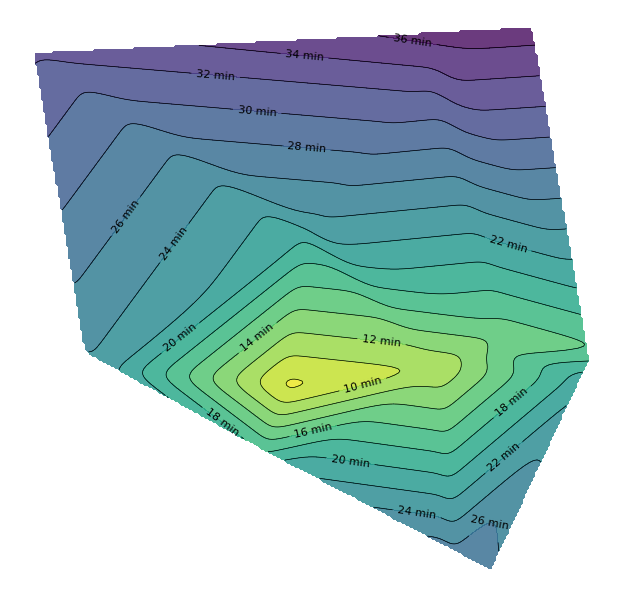

In [26]:
#m = plot_travel_time_heatmap_folium(df_loaded, center_point=city_data[city]["center"], show_contours=True, show_markers=True, show_center_marker=False)
#m

m = plot_travel_time_heatmap_folium(df_loaded, center_point=city_data[city]["center"])
print(city_data[city]["center"])

m



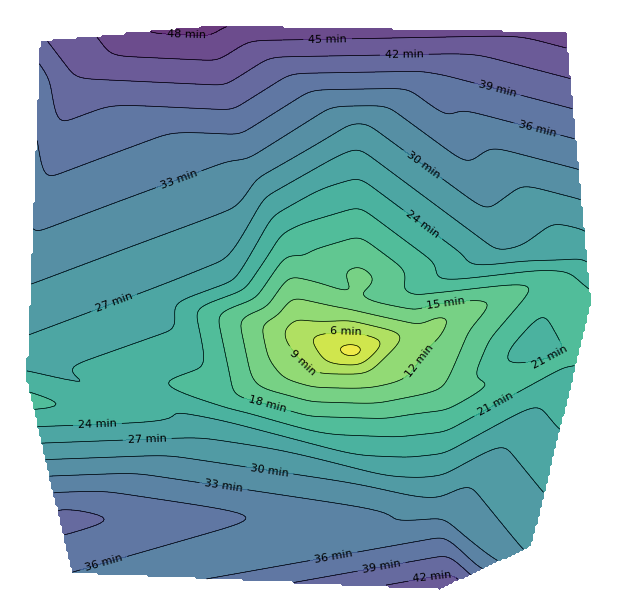

In [135]:
m = plot_travel_time_heatmap_folium(df_with_times2, center_point=city_data[city]["center"], show_contours=True, show_markers=False, show_center_marker=False)

m


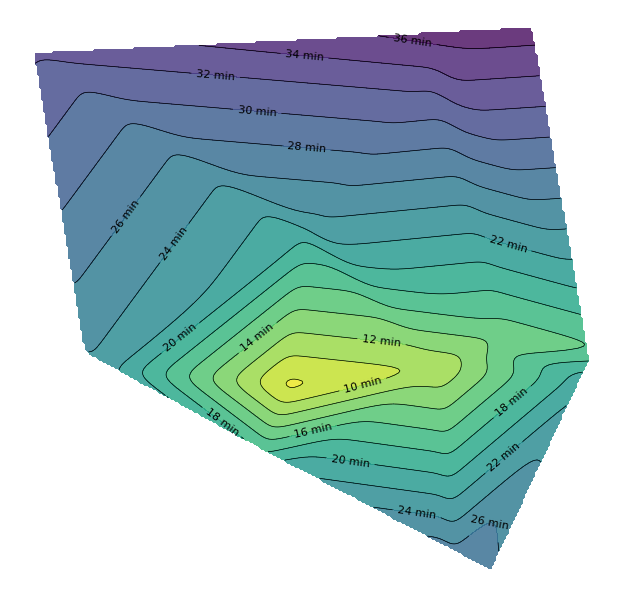

In [86]:
m = plot_travel_time_heatmap_folium(df_with_times, center_point=city_data[city]["center"], show_contours=True, show_center_marker=False)

m

In [3]:
import pickle

def save_city_data(df, city_name, filepath="city_data.pkl"):
    data = {
        "city": city_name,
        "dataframe": df
    }
    with open(filepath, "wb") as f:
        pickle.dump(data, f)
    print(f"Saved data for {city_name} to {filepath}")

def load_city_data(filepath="city_data.pkl"):
    with open(filepath, "rb") as f:
        data = pickle.load(f)
    city_name = data["city"]
    df = data["dataframe"]
    print(f"Loaded data for {city_name} from {filepath}")
    return city_name, df


In [136]:
save_city_data(df_with_times2, city_name="bristol", filepath="bristol_data.pkl")
save_city_data(df_with_times, city_name="bristol", filepath="bristol1_data.pkl")

Saved data for bristol to bristol_data.pkl
Saved data for bristol to bristol1_data.pkl


In [76]:
# Save data
save_city_data(df_with_times, city_name="bradford", filepath="bradford_data.pkl")

Saved data for bradford to bradford_data.pkl


In [14]:
city, df_loaded = load_city_data("data/bradford.pkl")


Loaded data for bradford from data/bradford.pkl


In [15]:
print(df_loaded.head())

  postcode        lat       lon  travel_time_mins
0  BS1 1DD  51.459757 -2.574944         15.033333
1  BS1 1BU  51.453654 -2.593938          7.016667
2  BS1 1DP  51.454904 -2.594327          8.266667
3  BS2 0AF  51.455572 -2.580866         10.200000
4  BS2 0AS  51.457986 -2.573094         14.666667



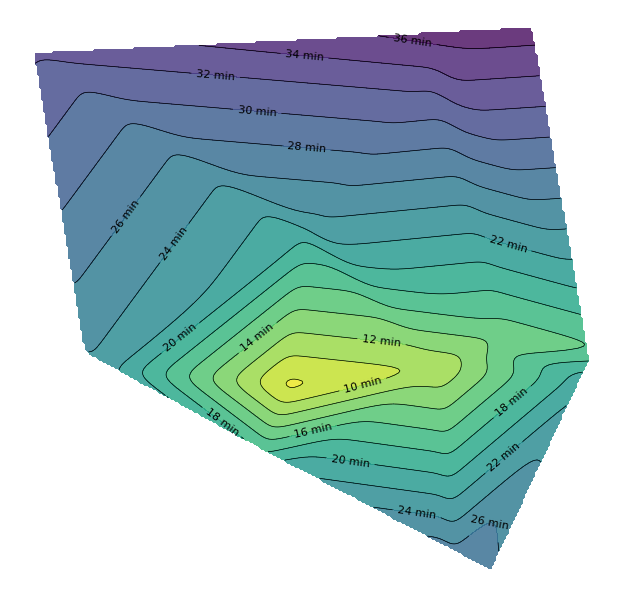

In [12]:
m = plot_travel_time_heatmap_folium(df_loaded, center_point=city_data[city]["center"], show_contours=True, show_markers=True, show_center_marker=False)

m

In [ ]:
import time

GOOGLE_API_KEY = "YOUR_API_KEY"  # Replace with your actual key
ORIGIN = "Leeds Station, Leeds"  # or use (lat, lon) as string: "53.7950,-1.5486"
MODE = "transit"  # change to "bicycling" for cycling mode

def get_travel_time(origin, dest_lat, dest_lon, mode="transit"):
    dest = f"{dest_lat},{dest_lon}"
    url = (
        f"https://maps.googleapis.com/maps/api/distancematrix/json"
        f"?origins={origin}"
        f"&destinations={dest}"
        f"&mode={mode}"
        f"&key={GOOGLE_API_KEY}"
    )
    r = requests.get(url)
    if r.status_code != 200:
        return None
    result = r.json()
    try:
        duration_sec = result["rows"][0]["elements"][0]["duration"]["value"]
        return duration_sec / 60  # convert to minutes
    except (KeyError, IndexError, TypeError):
        return None

# Add travel times
df["travel_time_min"] = df.apply(
    lambda row: get_travel_time(ORIGIN, row["lat"], row["lon"], mode=MODE),
    axis=1
)

# Optional: Save to file
df.to_csv("leeds_postcodes_with_travel_times.csv", index=False)


In [4]:
import folium
from folium.plugins import MarkerCluster

def plot_postcodes_on_map(postcodes_df, center=None, zoom=11, color='blue'):
    """
    Plot a set of postcodes (lat/lon) on an interactive folium map.

    Args:
        postcodes_df (pd.DataFrame): Must contain 'lat' and 'lon' columns.
        center (tuple): Optional (lat, lon) to center the map.
        zoom (int): Initial zoom level.
        color (str): Marker color.

    Returns:
        folium.Map object.
    """
    if center is None:
        center = (
            postcodes_df["lat"].mean(),
            postcodes_df["lon"].mean()
        )

    m = folium.Map(location=center, zoom_start=zoom, tiles="CartoDB positron")

    marker_cluster = MarkerCluster().add_to(m)

    for _, row in postcodes_df.iterrows():
        popup_text = row.get("postcode", "Unknown")
        folium.CircleMarker(
            location=(row["lat"], row["lon"]),
            radius=4,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6,
            popup=popup_text
        ).add_to(marker_cluster)

    return m


In [ ]:
import googlemaps
from datetime import datetime
import random

gmaps = googlemaps.Client(key=google_maps_api_key)

coords = get_coords((51.507200, -0.127600), num=10)


https://docs.mapbox.com/api/navigation/isochrone/
